# Lab 4
> ## Joshua Min
> ## ID: 7926218082
> ## Email: minje@usc.edu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from IPython.display import display, Markdown

## Data Reading  


In [2]:
# Reading in CSV
data = pd.read_csv('./YouTube-Spam-Collection-v1/Youtube04-Eminem.csv')

> ## TF-IDF
> Here I take the entirety of the *CONTENT* column of the train dataset as my corpus.  
> Each row in the column is a document.  
> I then add a new column to the dataframe with the dense TF-IDF vector of each comment.  

In [3]:
v = TfidfVectorizer()
x = v.fit_transform(data.CONTENT).toarray()
data['CONTENT_VEC'] = list(x)

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
443    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
444    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
445    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1133483022881...
446    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
447    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: CONTENT_VEC, Length: 448, dtype: object


## Data Splitting
> Here I split the data into train and test sets.  

In [4]:
# Separating classes
ham = data.loc[data['CLASS'] == 0]
spam = data.loc[data['CLASS'] == 1]

# Getting row count of both classes
ham_total = ham.shape[0]
spam_total = spam.shape[0]
ham_train_end = round(ham_total * 0.8)
spam_train_end = round(spam_total * 0.8)

# Splitting into train and test sets
train = pd.concat([
    ham[0:ham_train_end],
    spam[0:spam_train_end]
])
test = pd.concat([
    ham[ham_train_end:],
    spam[spam_train_end:]
])

## Helper Functions
> Here I define a few helper functions to make generating score reports easier

In [5]:
# This code was taken from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# It gives a graphical printout of the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j , i - 0.25 if i > 0 else i + 0.25, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=12,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
# Helper function for generating a report containing:
# Confusion Matrix, accuracy, precison, recall, F1-Score, ROC curve, AUC
def clf_report(clf, dataset, dataset_title=None):
    if dataset_title:
        display(Markdown(f'### Dataset: {dataset_title}'))
    true = dataset.CLASS
    pred = clf.predict(dataset.CONTENT_VEC.tolist())
    prob = clf.predict_proba(dataset.CONTENT_VEC.tolist())
    display(Markdown(metrics.classification_report(true, pred)))
    plot_confusion_matrix(true, pred, ["Ham", "Spam"], title="Confusion Matrix")
    fpr, tpr, _ = metrics.roc_curve(true, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## L1-Penalized Logistic Regression  
> Here I train and test the model on a 5-fold CV L1-Penalized Logistic Regression model.  

In [12]:
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
l1_clf = LogisticRegressionCV(
    Cs=lambdas,
    cv=5,
    random_state=0,
    n_jobs=4,
    solver='liblinear',
    penalty='l1'
).fit(
    train.CONTENT_VEC.tolist(),
    train.CLASS
)

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

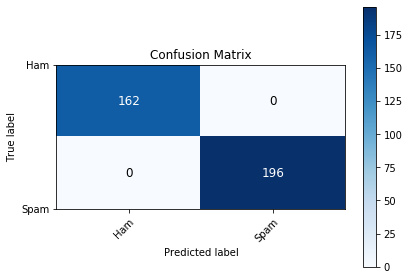

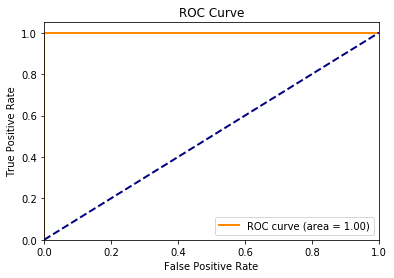

In [13]:
# Report for training set
clf_report(l1_clf, train, dataset_title="Train")

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

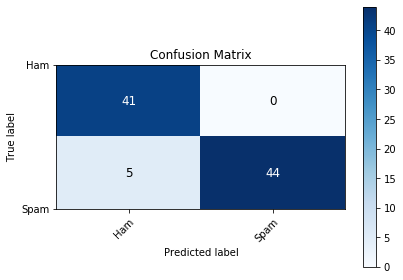

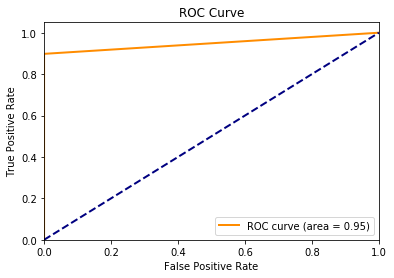

In [9]:
# Report for test set
clf_report(l1_clf, test, dataset_title="Test")

## Which is more important in this application, precision or recall?
> In this application, precision measures the percentage of predicted spam comments that were correctly classified, whereas recall measures the percentage of actual spam comments that were correctly classified. With this in mind, **recall** would be more important in this application because it yields us a better sense of how well our classifier is performing.  

## L2-Penalized Logistic Regression  
> Here I train and test the model on a 5-fold CV L1-Penalized Logistic Regression model.  

In [14]:
l2_clf = LogisticRegressionCV(
    Cs=lambdas,
    cv=5,
    random_state=0,
    n_jobs=4,
    solver='liblinear',
    penalty='l2'
).fit(
    train.CONTENT_VEC.tolist(),
    train.CLASS
)

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

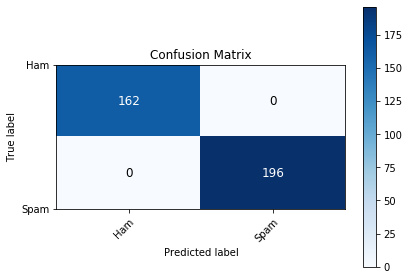

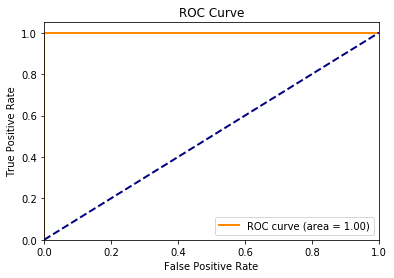

In [15]:
clf_report(l2_clf, train, dataset_title="Train")

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

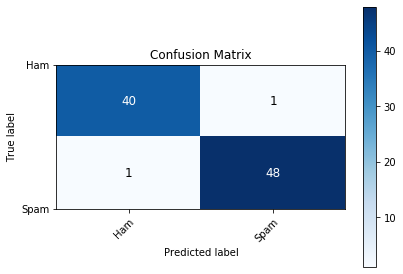

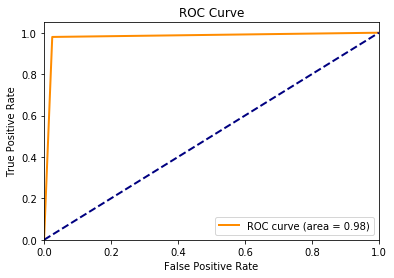

In [16]:
clf_report(l2_clf, test, dataset_title="Test")

## Naive Bayes' Classification
> Here I train and test a Naive Bayes' classifier with Gaussian class conditional distributions


In [17]:
nb_clf = GaussianNB().fit(
    train.CONTENT_VEC.tolist(),
    train.CLASS
)

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

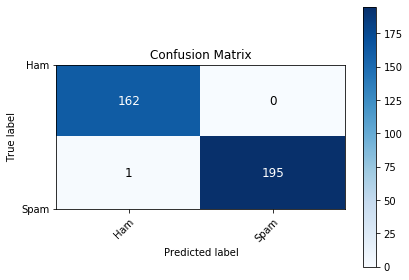

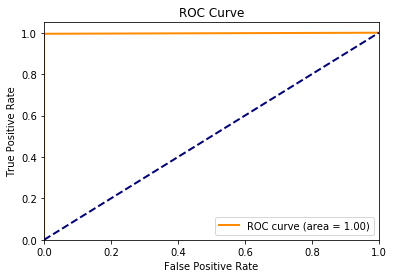

In [18]:
clf_report(nb_clf, train, dataset_title="Train")

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

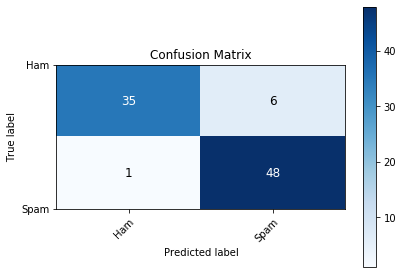

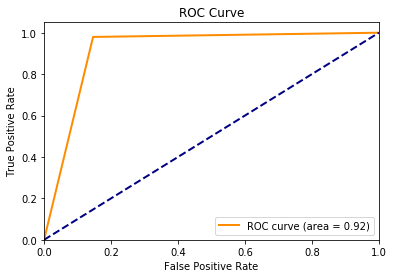

In [19]:
clf_report(nb_clf, test, dataset_title="Test")

## Multinomial Naive Bayes' Classification
> Here I train and test a Multinomial Naive Bayes' classifier with Gaussian class conditional distributions


In [20]:
mnb_clf = MultinomialNB().fit(
    train.CONTENT_VEC.tolist(),
    train.CLASS
)

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

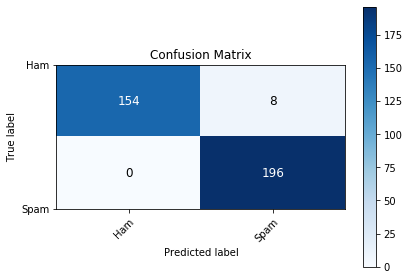

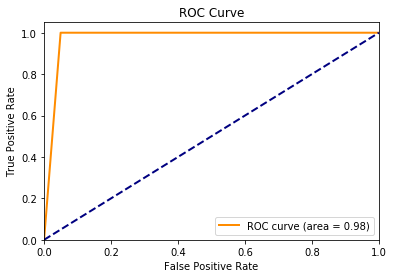

In [21]:
clf_report(mnb_clf, train, dataset_title="Train")

<IPython.core.display.Markdown object>

<IPython.core.display.Markdown object>

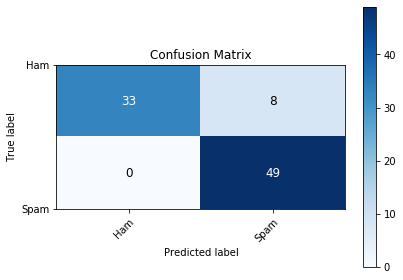

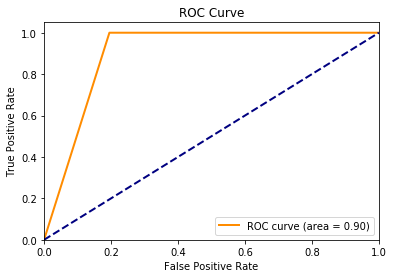

In [22]:
clf_report(mnb_clf, test, dataset_title="Test")